# 🧮 AI Mathematical Olympiad - Full Training on Colab

**Comprehensive Training Notebook for Mathematical Reasoning Model**

This notebook trains a transformer model on the full MATH dataset (~7,500 problems) with:
- ✅ Properly sized model for available data
- ✅ Full dataset (not just 500 examples)
- ✅ Real-time monitoring and sample generation
- ✅ Early stopping and checkpointing
- ✅ GPU acceleration (50x faster than CPU)

---

## 📝 Instructions

1. **Runtime Setup**: Runtime → Change runtime type → GPU (T4)
2. **Run All**: Runtime → Run all
3. **Training Time**: ~2-4 hours on free Colab T4 GPU
4. **Checkpoints**: Saved to Google Drive (optional, see Step 1)

---

## Step 0: Check GPU Availability

In [1]:
import torch

if torch.cuda.is_available():
    gpu_name = torch.cuda.get_device_name(0)
    print(f"✅ GPU Available: {gpu_name}")
    print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    print("⚠️ No GPU detected! Go to Runtime → Change runtime type → GPU")
    print("   Training on CPU will be 50x slower.")

✅ GPU Available: NVIDIA A100-SXM4-80GB
   Memory: 85.17 GB


## Step 1: Mount Google Drive (Optional - for saving checkpoints)

In [2]:
from google.colab import drive
import os

# Uncomment the next line to save checkpoints to Google Drive
# drive.mount('/content/drive')

# Set checkpoint directory
USE_GDRIVE = False  # Set to True if you mounted Drive
if USE_GDRIVE:
    CHECKPOINT_DIR = '/content/drive/MyDrive/math_model_checkpoints'
else:
    CHECKPOINT_DIR = '/content/checkpoints'

os.makedirs(CHECKPOINT_DIR, exist_ok=True)
print(f"✅ Checkpoints will be saved to: {CHECKPOINT_DIR}")

✅ Checkpoints will be saved to: /content/checkpoints


## Step 2: Install Dependencies and Clone Repository

In [3]:
# Install dependencies
!pip install -q datasets transformers tokenizers tqdm matplotlib

# Clone the repository
!git clone https://github.com/Alpyaman/AI-Mathematical-Olympiad.git
%cd AI-Mathematical-Olympiad

print("✅ Repository cloned and dependencies installed")

Cloning into 'AI-Mathematical-Olympiad'...
remote: Enumerating objects: 225, done.
remote: Counting objects: 100% (110/110), done.
remote: Compressing objects: 100% (80/80), done.
remote: Total 225 (delta 44), reused 67 (delta 30), pack-reused 115 (from 1)
Receiving objects: 100% (225/225), 11.36 MiB | 17.87 MiB/s, done.
Resolving deltas: 100% (73/73), done.
/content/AI-Mathematical-Olympiad
✅ Repository cloned and dependencies installed


## Step 3: Configuration - Optimized for Full Dataset

In [4]:
# ============================
# TRAINING CONFIGURATION
# ============================

# Model Size (choose one):
MODEL_SIZE = "tiny"  # Options: "tiny" (~20M params), "small" (~85M params), "medium" (~350M params)

# Training Hyperparameters
BATCH_SIZE = 8           # Increase if you have more GPU memory
GRAD_ACCUM_STEPS = 4     # Effective batch size = 32
LEARNING_RATE = 5e-4     # Lower than before for stability
MAX_EPOCHS = 30          # More epochs with early stopping
WARMUP_STEPS = 200       # Learning rate warmup
MAX_LENGTH = 512        # Longer sequences for full solutions

# Early Stopping
PATIENCE = 5             # Stop if no improvement for N epochs
MIN_DELTA = 0.01         # Minimum improvement to count

# Monitoring
LOG_EVERY = 50           # Log metrics every N steps
SAMPLE_EVERY = 200       # Generate samples every N steps
SAVE_EVERY_EPOCH = 5     # Save checkpoint every N epochs

# Dataset
USE_FULL_DATASET = True  # True = ~7.5k examples, False = 500 examples
TRAIN_SPLIT = 0.85       # 85% train, 10% val, 5% test
VAL_SPLIT = 0.10
TEST_SPLIT = 0.05

print(f"""\n{'='*60}
TRAINING CONFIGURATION
{'='*60}
Model Size:        {MODEL_SIZE}
Effective Batch:   {BATCH_SIZE * GRAD_ACCUM_STEPS}
Learning Rate:     {LEARNING_RATE}
Max Epochs:        {MAX_EPOCHS}
Sequence Length:   {MAX_LENGTH}
Full Dataset:      {USE_FULL_DATASET}
{'='*60}\n""")


TRAINING CONFIGURATION
Model Size:        tiny
Effective Batch:   32
Learning Rate:     0.0005
Max Epochs:        30
Sequence Length:   512
Full Dataset:      True



## Step 4: Load and Prepare Dataset

In [5]:
from datasets import load_dataset
from tqdm import tqdm
from src.data.data_schema import MathProblem, MathSolution, ReasoningStep, DifficultyLevel, ProblemType
import re

def convert_hf_to_schema(hf_dataset):
    """Convert HuggingFace MATH dataset to our schema"""
    problems = []
    print("🔄 Converting dataset...")

    for i, item in enumerate(tqdm(hf_dataset)):
        # Map difficulty if available
        level_map = {
            1: DifficultyLevel.EASY,
            2: DifficultyLevel.MEDIUM,
            3: DifficultyLevel.MEDIUM,
            4: DifficultyLevel.HARD,
            5: DifficultyLevel.OLYMPIAD,
        }
        difficulty = level_map.get(item.get('level', 2), DifficultyLevel.MEDIUM)

        # Map problem type
        type_map = {
            'algebra': ProblemType.ALGEBRA,
            'counting_and_probability': ProblemType.COMBINATORICS,
            'geometry': ProblemType.GEOMETRY,
            'intermediate_algebra': ProblemType.ALGEBRA,
            'number_theory': ProblemType.NUMBER_THEORY,
            'prealgebra': ProblemType.ALGEBRA,
            'precalculus': ProblemType.ALGEBRA,
        }
        prob_type = type_map.get(item.get('type', 'algebra'), ProblemType.ALGEBRA)

        # Extract answer safely
        final_answer = item.get('answer')
        if final_answer is None:
            # Try to find boxed answer in solution
            # Note: This is a simple regex and might not catch complex nested braces
            matches = re.findall(r'\\boxed{(.+?)}', item['solution'])
            if matches:
                final_answer = matches[-1]
            else:
                final_answer = "Unknown"

        # Create solution (wrap in single step for now)
        sol = MathSolution(
            steps=[ReasoningStep(1, "Solution", item['solution'], None)],
            final_answer=final_answer,
            answer_type="exact",
            verification=None
        )

        prob = MathProblem(
            problem_id=f"MATH_{i}",
            problem_statement=item['problem'],
            solution=sol,
            difficulty=difficulty,
            problem_type=prob_type,
            topics=[item.get('type', 'math')],
            source="MATH",
            year=2024
        )
        problems.append(prob)

    return problems

# Load dataset
print(f"\n📚 Loading {'FULL' if USE_FULL_DATASET else 'MATH-500'} dataset...")

if USE_FULL_DATASET:
    # Load full MATH dataset (~7,500 problems)
    try:
        dataset_hf = load_dataset("lighteval/MATH", split="train")
    except:
        print("   Trying alternative dataset...")
        # Use 'qwedsacf/competition_math' found in search
        try:
            dataset_hf = load_dataset("qwedsacf/competition_math", split="train")
        except:
             # Fallback to EleutherAI version if the above fails
             dataset_hf = load_dataset("EleutherAI/hendrycks_math", split="train")
else:
    # Load MATH-500 (small subset for quick testing)
    dataset_hf = load_dataset("HuggingFaceH4/MATH-500", split="test")

print(f"   Loaded {len(dataset_hf)} problems")

# Convert to our schema
problems = convert_hf_to_schema(dataset_hf)

# Split dataset
from src.data.dataset import split_dataset
train_probs, val_probs, test_probs = split_dataset(
    problems,
    TRAIN_SPLIT,
    VAL_SPLIT,
    TEST_SPLIT
)

print(f"\n✅ Dataset prepared:")
print(f"   Train:      {len(train_probs)} problems")
print(f"   Validation: {len(val_probs)} problems")
print(f"   Test:       {len(test_probs)} problems")


📚 Loading FULL dataset...
   Trying alternative dataset...


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001-7320a6f3aba8eb(…):   0%|          | 0.00/4.85M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/12500 [00:00<?, ? examples/s]

   Loaded 12500 problems
🔄 Converting dataset...


100%|██████████| 12500/12500 [00:00<00:00, 15950.05it/s]


✅ Dataset prepared:
   Train:      10625 problems
   Validation: 1250 problems
   Test:       625 problems


In [6]:
# Initialize tokenizer FIRST and reuse it everywhere
from src.tokenizer.math_tokenizer import MathTokenizer

tokenizer = MathTokenizer()
VOCAB_SIZE = len(tokenizer)  # Should be 544

print(f"✅ Tokenizer initialized: {VOCAB_SIZE} tokens")
print(f"   This MUST match the model's vocab_size!")

✅ Tokenizer initialized: 544 tokens
   This MUST match the model's vocab_size!


## Step 5: Initialize Model and Tokenizer

In [7]:
from src.config.model_config import MathTransformerConfig, get_small_config
from src.model.decoder import MathTransformerDecoder
from src.tokenizer.math_tokenizer import MathTokenizer
from src.data.dataset import MathReasoningDataset, create_dataloaders

# Model configuration
def get_config(size="tiny"):
    """Get model configuration based on size"""
    if size == "tiny":
        return MathTransformerConfig(
            hidden_size=256,
            num_hidden_layers=6,
            num_attention_heads=8,
            intermediate_size=1024,
            max_position_embeddings=1024,
            max_sequence_length=1024,
            hidden_dropout=0.2,
            attention_dropout=0.1,
        )
    elif size == "small":
        return get_small_config()
    elif size == "medium":
        return MathTransformerConfig(
            hidden_size=768,
            num_hidden_layers=12,
            num_attention_heads=12,
            intermediate_size=3072,
            max_position_embeddings=2048,
            max_sequence_length=2048,
        )
    else:
        raise ValueError(f"Unknown model size: {size}")

# Initialize
print("\n🔧 Initializing model...")
device = "cuda" if torch.cuda.is_available() else "cpu"
config = get_config(MODEL_SIZE)
config.vocab_size = VOCAB_SIZE  # CRITICAL: Set to match tokenizer!
model = MathTransformerDecoder(config).to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\n✅ Model initialized:")
print(f"   Size:              {MODEL_SIZE}")
print(f"   Total parameters:  {total_params:,}")
print(f"   Trainable params:  {trainable_params:,}")
print(f"   Device:            {device}")
print(f"   Hidden size:       {config.hidden_size}")
print(f"   Layers:            {config.num_hidden_layers}")
print(f"   Attention heads:   {config.num_attention_heads}")

# Data-to-parameter ratio
ratio = len(train_probs) / (total_params / 1e6)
print(f"\n📊 Data-to-parameter ratio: {ratio:.1f} examples per million parameters")
if ratio < 10:
    print("   ⚠️ WARNING: Low ratio. Consider using a smaller model or more data.")
elif ratio < 50:
    print("   ℹ️ Acceptable ratio, but more data would help.")
else:
    print("   ✅ Good ratio for this task!")

# Initialize tokenizer and datasets
print("\n🔤 Initializing tokenizer and datasets...")
tokenizer = MathTokenizer()

train_ds = MathReasoningDataset(train_probs, tokenizer, max_length=MAX_LENGTH)
val_ds = MathReasoningDataset(val_probs, tokenizer, max_length=MAX_LENGTH)

train_loader, val_loader = create_dataloaders(
    train_ds,
    val_ds,
    batch_size=BATCH_SIZE,
    num_workers=2
)

print(f"✅ Dataloaders created:")
print(f"   Train batches: {len(train_loader)}")
print(f"   Val batches:   {len(val_loader)}")


🔧 Initializing model...

✅ Model initialized:
   Size:              tiny
   Total parameters:  6,573,312
   Trainable params:  6,573,312
   Device:            cuda
   Hidden size:       256
   Layers:            6
   Attention heads:   8

📊 Data-to-parameter ratio: 1616.4 examples per million parameters
   ✅ Good ratio for this task!

🔤 Initializing tokenizer and datasets...
✅ Dataloaders created:
   Train batches: 1329
   Val batches:   157


## Step 6: Training Setup (Optimizer, Scheduler, Early Stopping)

In [8]:
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
import numpy as np

# Optimizer
optimizer = AdamW(
    model.parameters(),
    lr=LEARNING_RATE,
    weight_decay=0.01,
    betas=(0.9, 0.95)
)

# Learning rate scheduler with warmup
total_steps = len(train_loader) * MAX_EPOCHS // GRAD_ACCUM_STEPS
scheduler = OneCycleLR(
    optimizer,
    max_lr=LEARNING_RATE,
    total_steps=total_steps,
    pct_start=0.05,  # 5% warmup
    anneal_strategy='cos',
    div_factor=25.0,
    final_div_factor=1000.0
)

# Early stopping tracker
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.01):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.should_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.should_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0
        return self.should_stop

early_stopping = EarlyStopping(patience=PATIENCE, min_delta=MIN_DELTA)

# Training metrics tracker
history = {
    'train_loss': [],
    'val_loss': [],
    'learning_rate': [],
    'epoch': []
}

print("✅ Training setup complete:")
print(f"   Optimizer:     AdamW (lr={LEARNING_RATE})")
print(f"   Scheduler:     OneCycleLR with warmup")
print(f"   Total steps:   {total_steps:,}")
print(f"   Early stopping patience: {PATIENCE} epochs")

✅ Training setup complete:
   Optimizer:     AdamW (lr=0.0005)
   Scheduler:     OneCycleLR with warmup
   Total steps:   9,967
   Early stopping patience: 5 epochs


## Step 7: Sample Generation Function (Monitor Training Progress)

In [9]:
def generate_sample(model, tokenizer, prompt, max_length=200):
    """Generate a sample response to monitor training progress"""
    model.eval()
    with torch.no_grad():
        # Encode prompt
        encoded = tokenizer.encode(prompt, add_special_tokens=False)
        input_ids = torch.tensor([encoded['input_ids']]).to(device)

        # Generate
        output_ids = model.generate(
            input_ids,
            max_new_tokens=max_length,
            temperature=0.8,
            top_k=50,
            top_p=0.9,
            eos_token_id=tokenizer.eos_token_id
        )

        # Decode
        output_text = tokenizer.decode(output_ids[0].cpu().tolist())

    model.train()
    return output_text

# Test problems for monitoring
TEST_PROMPTS = [
    "Problem: Solve for x: 2x + 5 = 13\n\nSolution:",
    "Problem: What is 7 × 8?\n\nSolution:",
    "Problem: If f(x) = 3x - 2, what is f(4)?\n\nSolution:"
]

print("✅ Sample generation function ready")

✅ Sample generation function ready


## Step 8: Main Training Loop

In [10]:
import time
from datetime import datetime

print(f"\n{'='*70}")
print(f"🚀 STARTING TRAINING")
print(f"{'='*70}")
print(f"Start time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Device: {device}")
print(f"{'='*70}\n")

best_val_loss = float('inf')
global_step = 0
start_time = time.time()

for epoch in range(MAX_EPOCHS):
    epoch_start = time.time()
    model.train()
    total_loss = 0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{MAX_EPOCHS}")

    for step, batch in enumerate(pbar):
        # Move to device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Forward pass
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs['loss'] / GRAD_ACCUM_STEPS

        # Backward pass
        loss.backward()
        total_loss += loss.item() * GRAD_ACCUM_STEPS

        # Update weights
        if (step + 1) % GRAD_ACCUM_STEPS == 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
            global_step += 1

            # Update progress bar
            current_lr = scheduler.get_last_lr()[0]
            pbar.set_postfix({
                'loss': f"{loss.item() * GRAD_ACCUM_STEPS:.4f}",
                'lr': f"{current_lr:.2e}"
            })

            # Generate samples periodically
            if global_step % SAMPLE_EVERY == 0:
                print(f"\n\n{'='*70}")
                print(f"📝 SAMPLE GENERATION (Step {global_step})")
                print(f"{'='*70}")
                for i, prompt in enumerate(TEST_PROMPTS[:2]):
                    print(f"\nTest {i+1}: {prompt[:50]}...")
                    print("-" * 70)
                    sample = generate_sample(model, tokenizer, prompt, max_length=150)
                    print(sample[:300])
                    print("-" * 70)
                print()

    # Validation
    model.eval()
    val_loss = 0
    val_steps = 0

    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validation", leave=False):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            val_loss += outputs['loss'].item()
            val_steps += 1

    # Calculate metrics
    avg_train_loss = total_loss / len(train_loader)
    avg_val_loss = val_loss / val_steps
    epoch_time = time.time() - epoch_start

    # Update history
    history['train_loss'].append(avg_train_loss)
    history['val_loss'].append(avg_val_loss)
    history['learning_rate'].append(scheduler.get_last_lr()[0])
    history['epoch'].append(epoch + 1)

    # Print epoch summary
    print(f"\n{'='*70}")
    print(f"EPOCH {epoch+1}/{MAX_EPOCHS} COMPLETE")
    print(f"{'='*70}")
    print(f"Train Loss:      {avg_train_loss:.4f}")
    print(f"Val Loss:        {avg_val_loss:.4f}")
    print(f"Learning Rate:   {scheduler.get_last_lr()[0]:.2e}")
    print(f"Epoch Time:      {epoch_time/60:.2f} minutes")
    print(f"Total Time:      {(time.time()-start_time)/60:.2f} minutes")

    # Save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': avg_val_loss,
            'config': config,
        }, f"{CHECKPOINT_DIR}/best_model.pt")
        print(f"✅ New best model saved! (val_loss: {avg_val_loss:.4f})")

    # Periodic checkpoint
    if (epoch + 1) % SAVE_EVERY_EPOCH == 0:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': avg_val_loss,
            'config': config,
        }, f"{CHECKPOINT_DIR}/checkpoint_epoch_{epoch+1}.pt")
        print(f"💾 Checkpoint saved (epoch {epoch+1})")

    print(f"{'='*70}\n")

    # Early stopping check
    if early_stopping(avg_val_loss):
        print(f"\n⚠️ Early stopping triggered after {epoch+1} epochs")
        print(f"   No improvement for {PATIENCE} epochs")
        print(f"   Best val loss: {best_val_loss:.4f}")
        break

# Training complete
total_time = time.time() - start_time
print(f"\n{'='*70}")
print(f"🏁 TRAINING COMPLETE!")
print(f"{'='*70}")
print(f"Total epochs:     {epoch+1}")
print(f"Total time:       {total_time/3600:.2f} hours")
print(f"Best val loss:    {best_val_loss:.4f}")
print(f"Final train loss: {avg_train_loss:.4f}")
print(f"{'='*70}\n")


🚀 STARTING TRAINING
Start time: 2025-12-20 17:24:08
Device: cuda



Epoch 1/30:  60%|█████▉    | 796/1329 [00:28<00:18, 28.84it/s, loss=2.7615, lr=1.87e-04]



📝 SAMPLE GENERATION (Step 200)

Test 1: Problem: Solve for x: 2x + 5 = 13

Solution:...
----------------------------------------------------------------------
Problem: Solve for x: 2x + 5 = 13 Solution: bin 1 4 + ioflepua $ fon $ $ 3ae + 1+ (1x^2= = 23 + 2$ 2 Ste = 3 11 + re 30$ $ren = tio + 1 2 130, 1^4$ 0 = = 3$ 6 be + - 11 0} be 2 $ c
----------------------------------------------------------------------

Test 2: Problem: What is 7 × 8?

Solution:...
----------------------------------------------------------------------


Epoch 1/30:  60%|██████    | 803/1329 [00:31<01:50,  4.78it/s, loss=2.6943, lr=1.89e-04]

Problem: What is 7 × 8? Solution: s the ute t pasioly it stin $x 1122$. Sof te 1$. $ t = Stian ion 1 Son 2$.. Stive the 3 1$ 11 12$$ 10}$ $. 5^2 \frac{107 6} 3 + So 1, ( 1+ be 1
----------------------------------------------------------------------



Epoch 1/30: 100%|██████████| 1329/1329 [00:49<00:00, 26.74it/s, loss=1.6318, lr=3.81e-04]



EPOCH 1/30 COMPLETE
Train Loss:      3.2881
Val Loss:        1.5918
Learning Rate:   3.81e-04
Epoch Time:      0.86 minutes
Total Time:      0.86 minutes
✅ New best model saved! (val_loss: 1.5918)



Epoch 2/30:  20%|██        | 268/1329 [00:09<00:36, 29.35it/s, loss=1.3362, lr=4.56e-04]



📝 SAMPLE GENERATION (Step 400)

Test 1: Problem: Solve for x: 2x + 5 = 13

Solution:...
----------------------------------------------------------------------
Problem: Solve for x: 2x + 5 = 13 Solution: $x^2+3x$ is desent common form $x^2+2x = 0.$ Step 1: Solution We have begin{align*}3x-6)=\boxed{6}$. 8
----------------------------------------------------------------------

Test 2: Problem: What is 7 × 8?

Solution:...
----------------------------------------------------------------------


Epoch 2/30:  21%|██        | 275/1329 [00:11<02:16,  7.70it/s, loss=1.4279, lr=4.57e-04]

Problem: What is 7 × 8? Solution: [begin{align*}100000010+0000)=\frac{1001}{100}+1000) = \boxed{10000}}$] 100
----------------------------------------------------------------------



Epoch 2/30:  81%|████████  | 1070/1329 [00:38<00:08, 29.23it/s, loss=0.9427, lr=5.00e-04]



📝 SAMPLE GENERATION (Step 600)

Test 1: Problem: Solve for x: 2x + 5 = 13

Solution:...
----------------------------------------------------------------------
Problem: Solve for x: 2x + 5 = 13 Solution: [ 15^3 + 2 + 1)(1-1)^2 + 10 + 88 + 11001 - 1101101001 + 1010101011100111 + 1011111011001111011111111111111111011111111111111111111111111111111111111
----------------------------------------------------------------------

Test 2: Problem: What is 7 × 8?

Solution:...
----------------------------------------------------------------------


Epoch 2/30:  81%|████████  | 1076/1329 [00:41<00:49,  5.08it/s, loss=1.0363, lr=5.00e-04]

Problem: What is 7 × 8? Solution: begin{align*} &=2(-3)(-3)(-6)-(-2)-(-5)-(-1-1)--(-1)-(-1-1)-(--2-1)---(-2-1)----1-1)--(--1)-------2)-----------------1)-----------------------------
----------------------------------------------------------------------



Epoch 2/30: 100%|██████████| 1329/1329 [00:49<00:00, 26.65it/s, loss=1.2228, lr=5.00e-04]



EPOCH 2/30 COMPLETE
Train Loss:      1.2983
Val Loss:        1.0365
Learning Rate:   5.00e-04
Epoch Time:      0.87 minutes
Total Time:      1.73 minutes
✅ New best model saved! (val_loss: 1.0365)



Epoch 3/30:  41%|████      | 542/1329 [00:18<00:26, 29.47it/s, loss=1.0909, lr=4.99e-04]



📝 SAMPLE GENERATION (Step 800)

Test 1: Problem: Solve for x: 2x + 5 = 13

Solution:...
----------------------------------------------------------------------
Problem: Solve for x: 2x + 5 = 13 Solution: begin{align*} 3x-5 &= 1 end{align*} Step 1: Solution If $x = 3 &= \frac{1}{3} end{align*} Thus, $x = \boxed{-3}$. -1
----------------------------------------------------------------------

Test 2: Problem: What is 7 × 8?

Solution:...
----------------------------------------------------------------------


Epoch 3/30:  41%|████      | 548/1329 [00:20<02:06,  6.18it/s, loss=1.0619, lr=4.99e-04]

Problem: What is 7 × 8? Solution: $$$ Step 1: Solution Since $85=9-4$ is the sum of the form $x$ and $x-2$ and $x-5=\boxed{1}$. -1
----------------------------------------------------------------------



Epoch 3/30: 100%|██████████| 1329/1329 [00:47<00:00, 27.72it/s, loss=1.0893, lr=4.97e-04]



EPOCH 3/30 COMPLETE
Train Loss:      1.0235
Val Loss:        0.9046
Learning Rate:   4.97e-04
Epoch Time:      0.83 minutes
Total Time:      2.57 minutes
✅ New best model saved! (val_loss: 0.9046)



Epoch 4/30:   1%|          | 13/1329 [00:00<00:49, 26.85it/s, loss=0.9379, lr=4.97e-04]



📝 SAMPLE GENERATION (Step 1000)

Test 1: Problem: Solve for x: 2x + 5 = 13

Solution:...
----------------------------------------------------------------------
Problem: Solve for x: 2x + 5 = 13 Solution: $x^3 + 5x - 8 = 0$. Step 1: Solution We can factor to find the roots of the equation $x^2 + 5x + 3 = 0$ or $x^2 + 14x + 18 = 0$. This sum of
----------------------------------------------------------------------

Test 2: Problem: What is 7 × 8?

Solution:...
----------------------------------------------------------------------


Epoch 4/30:   1%|▏         | 19/1329 [00:03<04:47,  4.56it/s, loss=0.9458, lr=4.97e-04]

Problem: What is 7 × 8? Solution: $$ The remainder is $100$ such that $n > 10$? Step 1: Solution Since $n$ is a multiple of $100 + n = 5$ is divisible by 5 and $n$ we are told
----------------------------------------------------------------------



Epoch 4/30:  61%|██████    | 813/1329 [00:30<00:17, 29.07it/s, loss=1.0170, lr=4.93e-04]



📝 SAMPLE GENERATION (Step 1200)

Test 1: Problem: Solve for x: 2x + 5 = 13

Solution:...
----------------------------------------------------------------------
Problem: Solve for x: 2x + 5 = 13 Solution: $$ x^2 + 5x + 2 = 25$$ Step 1: Solution We count that $2x + 5 = 23$, then $x = 24$ and $x = 24$. So $x = 25$. Then, $x = 36$ and $x = 2$ and $
----------------------------------------------------------------------

Test 2: Problem: What is 7 × 8?

Solution:...
----------------------------------------------------------------------


Epoch 4/30:  62%|██████▏   | 819/1329 [00:33<01:41,  5.00it/s, loss=0.8583, lr=4.93e-04]

Problem: What is 7 × 8? Solution: $$36.46 = 8.3 2.1 + 0.1 \cdot 5 .3 + 1.003 &.54.1 + 1.4 + 1.2.14.05 0.0 1.5 - 1..1.2.1.0.1.0.1.021..3 - 0.0.14 0.110313 & 000.1000 &0 &.00.1010.
----------------------------------------------------------------------



Epoch 4/30: 100%|██████████| 1329/1329 [00:50<00:00, 26.25it/s, loss=0.7558, lr=4.91e-04]



EPOCH 4/30 COMPLETE
Train Loss:      0.9114
Val Loss:        0.8297
Learning Rate:   4.91e-04
Epoch Time:      0.88 minutes
Total Time:      3.45 minutes
✅ New best model saved! (val_loss: 0.8297)



Epoch 5/30:  22%|██▏       | 287/1329 [00:10<00:35, 29.21it/s, loss=0.7790, lr=4.89e-04]



📝 SAMPLE GENERATION (Step 1400)

Test 1: Problem: Solve for x: 2x + 5 = 13

Solution:...
----------------------------------------------------------------------
Problem: Solve for x: 2x + 5 = 13 Solution: $x=2000$. Step 1: Solution Simplifying the sum of the equations gives $x=40000 = \boxed{120000}$. 120000
----------------------------------------------------------------------

Test 2: Problem: What is 7 × 8?

Solution:...
----------------------------------------------------------------------


Epoch 5/30:  22%|██▏       | 293/1329 [00:12<03:12,  5.39it/s, loss=0.7979, lr=4.89e-04]

Problem: What is 7 × 8? Solution: $1200 \cdot 20000 + 000000000}$ Step 1: Solution We want to count the number that a gives [100000000000 = 000000000000000000000000000000000000000
----------------------------------------------------------------------



Epoch 5/30:  82%|████████▏ | 1085/1329 [00:40<00:08, 29.26it/s, loss=0.8202, lr=4.83e-04]



📝 SAMPLE GENERATION (Step 1600)

Test 1: Problem: Solve for x: 2x + 5 = 13

Solution:...
----------------------------------------------------------------------
Problem: Solve for x: 2x + 5 = 13 Solution: $$x + y = 13 + 15 = -34 + 100 = \boxed{15}.$$ 15
----------------------------------------------------------------------

Test 2: Problem: What is 7 × 8?

Solution:...
----------------------------------------------------------------------


Epoch 5/30:  82%|████████▏ | 1092/1329 [00:41<00:31,  7.52it/s, loss=0.8960, lr=4.83e-04]

Problem: What is 7 × 8? Solution: begin{align*} &5 &\text{(C)} 2 &\text{(D)} 6 & 5 & 2 & 4 & 2 & 4 & 5 & 4 & 7 & 4 & 1 & 2 & 8 & 3 & 1 & 3 & & 3 & 7 & 7 & &&&&&&&2&&& 3&&&&&&&7&5&&7&4&&&5
----------------------------------------------------------------------



Epoch 5/30: 100%|██████████| 1329/1329 [00:50<00:00, 26.52it/s, loss=0.8166, lr=4.82e-04]



EPOCH 5/30 COMPLETE
Train Loss:      0.8376
Val Loss:        0.7747
Learning Rate:   4.82e-04
Epoch Time:      0.87 minutes
Total Time:      4.32 minutes
✅ New best model saved! (val_loss: 0.7747)
💾 Checkpoint saved (epoch 5)



Epoch 6/30:  42%|████▏     | 559/1329 [00:19<00:26, 28.84it/s, loss=0.8515, lr=4.77e-04]



📝 SAMPLE GENERATION (Step 1800)

Test 1: Problem: Solve for x: 2x + 5 = 13

Solution:...
----------------------------------------------------------------------
Problem: Solve for x: 2x + 5 = 13 Solution: $x = 4$ Step 1: Solution $(x+5) = 4 - 13 = 0$ and $x = -13 + 5 = \boxed{-3}$. -3
----------------------------------------------------------------------

Test 2: Problem: What is 7 × 8?

Solution:...
----------------------------------------------------------------------


Epoch 6/30:  43%|████▎     | 565/1329 [00:21<01:50,  6.92it/s, loss=0.8100, lr=4.77e-04]

Problem: What is 7 × 8? Solution: $\pi = \pi (8.8)$ Step 1: Solution $y = \pi \cdot 3.8 = 0.8.8 = 1.8 + 2.8 = 0.8 = \boxed{8.8}$ 8.8
----------------------------------------------------------------------



Epoch 6/30: 100%|██████████| 1329/1329 [00:47<00:00, 27.98it/s, loss=0.7627, lr=4.70e-04]



EPOCH 6/30 COMPLETE
Train Loss:      0.7846
Val Loss:        0.7436
Learning Rate:   4.70e-04
Epoch Time:      0.83 minutes
Total Time:      5.15 minutes
✅ New best model saved! (val_loss: 0.7436)



Epoch 7/30:   2%|▏         | 29/1329 [00:01<00:45, 28.86it/s, loss=0.7155, lr=4.70e-04]



📝 SAMPLE GENERATION (Step 2000)

Test 1: Problem: Solve for x: 2x + 5 = 13

Solution:...
----------------------------------------------------------------------
Problem: Solve for x: 2x + 5 = 13 Solution: $10x + 5 = 84 \Rightarrow x = \boxed{13}$. Step 1: Solution First we can rewrite the given equation by 4 and subtracting 2 from both sides gives $x = 2 +
----------------------------------------------------------------------

Test 2: Problem: What is 7 × 8?

Solution:...
----------------------------------------------------------------------


Epoch 7/30:   3%|▎         | 35/1329 [00:03<04:20,  4.96it/s, loss=0.6309, lr=4.70e-04]

Problem: What is 7 × 8? Solution: $$\frac{1}{4}$$ Step 1: Solution To find the numerator and denominator, $$\frac{1}{4} = \frac{1}{4}.$$We can eliminate the numerator and a number that is
----------------------------------------------------------------------



Epoch 7/30:  62%|██████▏   | 830/1329 [00:31<00:17, 29.05it/s, loss=0.6656, lr=4.61e-04]



📝 SAMPLE GENERATION (Step 2200)

Test 1: Problem: Solve for x: 2x + 5 = 13

Solution:...
----------------------------------------------------------------------
Problem: Solve for x: 2x + 5 = 13 Solution: $$ Step 1: Solution $2 + 3x = 12 + 2 = \boxed{12}$. 12
----------------------------------------------------------------------

Test 2: Problem: What is 7 × 8?

Solution:...
----------------------------------------------------------------------


Epoch 7/30:  63%|██████▎   | 836/1329 [00:32<00:55,  8.88it/s, loss=0.8463, lr=4.61e-04]

Problem: What is 7 × 8? Solution: $$ Step 1: Solution We have $8 \cdot 8 = 7 \cdot 6 = \boxed{7}$. 7
----------------------------------------------------------------------



Epoch 7/30: 100%|██████████| 1329/1329 [00:49<00:00, 26.82it/s, loss=0.6460, lr=4.55e-04]



EPOCH 7/30 COMPLETE
Train Loss:      0.7432
Val Loss:        0.7128
Learning Rate:   4.55e-04
Epoch Time:      0.86 minutes
Total Time:      6.01 minutes
✅ New best model saved! (val_loss: 0.7128)



Epoch 8/30:  23%|██▎       | 301/1329 [00:10<00:35, 29.02it/s, loss=0.7378, lr=4.52e-04]



📝 SAMPLE GENERATION (Step 2400)

Test 1: Problem: Solve for x: 2x + 5 = 13

Solution:...
----------------------------------------------------------------------
Problem: Solve for x: 2x + 5 = 13 Solution: $$\frac{2x+5}{x-1} = 13$$ Step 1: Solution Since $2x-3=-3$, we find that $x-3=-3$. Subtracting $2x-3=-3$ from both sides gives $2x-3=-3$. Subtrac
----------------------------------------------------------------------

Test 2: Problem: What is 7 × 8?

Solution:...
----------------------------------------------------------------------


Epoch 8/30:  23%|██▎       | 307/1329 [00:13<03:22,  5.04it/s, loss=0.7764, lr=4.52e-04]

Problem: What is 7 × 8? Solution: $7^3=2^4-2\cdot5^3+2$ Step 1: Solution We can write begin{align*} (7^3+2^3)(5^2-2)(5^3+2^3)&=(5^3-2^3)(5^3-2^3) &=(5^3-2)(5^3-2^3)(5^3) &=(5^
----------------------------------------------------------------------



Epoch 8/30:  83%|████████▎ | 1102/1329 [00:40<00:07, 28.65it/s, loss=0.6799, lr=4.42e-04]



📝 SAMPLE GENERATION (Step 2600)

Test 1: Problem: Solve for x: 2x + 5 = 13

Solution:...
----------------------------------------------------------------------
Problem: Solve for x: 2x + 5 = 13 Solution: $$x = \frac{2}{3} + 2.$$ Step 1: Solution Simplifying both sides by $3$ and 2, we get $5 + 2 = 3 \cdot 2 + 5 = \boxed{11}$. 11
----------------------------------------------------------------------

Test 2: Problem: What is 7 × 8?

Solution:...
----------------------------------------------------------------------


Epoch 8/30:  83%|████████▎ | 1108/1329 [00:42<00:42,  5.16it/s, loss=0.6770, lr=4.42e-04]

Problem: What is 7 × 8? Solution: $(-2 )(-3 + 4) + (-1 - 2) + (-3 - 2 + 4) + (- 1 - 4) + (-3 - 4 + 1) + (-1 - 2 + 3 + 4) + (- - 3 - 4 + 4) + (-3 - 4) + (-1 - 1 + 4) + (-2 - 1 + 1) + (
----------------------------------------------------------------------



Epoch 8/30: 100%|██████████| 1329/1329 [00:50<00:00, 26.25it/s, loss=0.6613, lr=4.39e-04]



EPOCH 8/30 COMPLETE
Train Loss:      0.7087
Val Loss:        0.6904
Learning Rate:   4.39e-04
Epoch Time:      0.88 minutes
Total Time:      6.90 minutes
✅ New best model saved! (val_loss: 0.6904)



Epoch 9/30:  43%|████▎     | 573/1329 [00:20<00:26, 28.12it/s, loss=0.7220, lr=4.31e-04]



📝 SAMPLE GENERATION (Step 2800)

Test 1: Problem: Solve for x: 2x + 5 = 13

Solution:...
----------------------------------------------------------------------
Problem: Solve for x: 2x + 5 = 13 Solution: $$ begin{array}{c@{}c@{}c} & 2 & 2 & 3 & 1 hline 2 & 1 & 3 & 1 hline 2 & 1 & & 1 & & hline & . & . & . end{array}$$ Step 1: Solut
----------------------------------------------------------------------

Test 2: Problem: What is 7 × 8?

Solution:...
----------------------------------------------------------------------


Epoch 9/30:  44%|████▎     | 579/1329 [00:22<02:29,  5.01it/s, loss=0.7566, lr=4.30e-04]

Problem: What is 7 × 8? Solution: $8^3\cdot8^4$ Step 1: Solution We subtract $8^3=24$ and $8^3=24$. First, we have $8^3=24$, so $4^3=89$. Therefore, $8^3=44$, $8^3=89$, and $89=89
----------------------------------------------------------------------



Epoch 9/30: 100%|██████████| 1329/1329 [00:48<00:00, 27.67it/s, loss=0.7794, lr=4.19e-04]



EPOCH 9/30 COMPLETE
Train Loss:      0.6794
Val Loss:        0.6712
Learning Rate:   4.19e-04
Epoch Time:      0.83 minutes
Total Time:      7.73 minutes
✅ New best model saved! (val_loss: 0.6712)



Epoch 10/30:   3%|▎         | 45/1329 [00:01<00:44, 28.97it/s, loss=0.6131, lr=4.19e-04]



📝 SAMPLE GENERATION (Step 3000)

Test 1: Problem: Solve for x: 2x + 5 = 13

Solution:...
----------------------------------------------------------------------
Problem: Solve for x: 2x + 5 = 13 Solution: $$\frac{1}{x} + \frac{1}{x} = \frac{5}{x}$$ Step 1: Solution We subtract $\frac{1}{x}$ from both sides gives $x = \frac{5}{x}$. Solving this equation gives $\frac{5}
----------------------------------------------------------------------

Test 2: Problem: What is 7 × 8?

Solution:...
----------------------------------------------------------------------


Epoch 10/30:   4%|▍         | 51/1329 [00:04<04:11,  5.08it/s, loss=0.6432, lr=4.19e-04]

Problem: What is 7 × 8? Solution: $\frac{2}{3}$ Step 1: Solution We can subtract $\frac{2}{3}$ from the denominator. We know that $\frac{2}{3}$ is equal to $\frac{2}{3}$, and the reciprocal o
----------------------------------------------------------------------



Epoch 10/30:  64%|██████▎   | 844/1329 [00:31<00:16, 29.03it/s, loss=0.6841, lr=4.06e-04]



📝 SAMPLE GENERATION (Step 3200)

Test 1: Problem: Solve for x: 2x + 5 = 13

Solution:...
----------------------------------------------------------------------
Problem: Solve for x: 2x + 5 = 13 Solution: $x = \frac{7}{3}$. Step 1: Solution $ x = \frac{7}{3}$ and $\frac{7}{3} = \boxed{-\frac{7}{3}}$. -\frac{7
----------------------------------------------------------------------

Test 2: Problem: What is 7 × 8?

Solution:...
----------------------------------------------------------------------


Epoch 10/30:  64%|██████▍   | 851/1329 [00:33<01:17,  6.18it/s, loss=0.5431, lr=4.06e-04]

Problem: What is 7 × 8? Solution: $\frac{2}{3}$ Step 1: Solution We have $\frac{2}{3} = \frac{2}{3}$ and $\frac{2}{3} = \frac{2}{3}$. Then $\frac{2}{3} = \frac{2}{3}$ and $\frac{2}{3} = \frac{2}{3}$. So $\frac{2}{
----------------------------------------------------------------------



Epoch 10/30: 100%|██████████| 1329/1329 [00:50<00:00, 26.50it/s, loss=0.8005, lr=3.98e-04]



EPOCH 10/30 COMPLETE
Train Loss:      0.6531
Val Loss:        0.6605
Learning Rate:   3.98e-04
Epoch Time:      0.87 minutes
Total Time:      8.61 minutes
✅ New best model saved! (val_loss: 0.6605)
💾 Checkpoint saved (epoch 10)



Epoch 11/30:  24%|██▍       | 317/1329 [00:11<00:34, 29.04it/s, loss=0.5373, lr=3.93e-04]



📝 SAMPLE GENERATION (Step 3400)

Test 1: Problem: Solve for x: 2x + 5 = 13

Solution:...
----------------------------------------------------------------------
Problem: Solve for x: 2x + 5 = 13 Solution: $\frac{x}{11}$ Step 1: Solution We can see that $\frac{x}{11}=\frac{5}{11}$ and $\frac{x}{11}=\boxed{\frac{2}{11}}$. \frac{2
----------------------------------------------------------------------

Test 2: Problem: What is 7 × 8?

Solution:...
----------------------------------------------------------------------


Epoch 11/30:  24%|██▍       | 323/1329 [00:13<02:42,  6.20it/s, loss=0.6729, lr=3.93e-04]

Problem: What is 7 × 8? Solution: $1 div 2 = 7.$ Step 1: Solution We have [ 1 div 1 = 1 \times 2 + 1 = 2 \times 2 + 1 = \boxed{20}. ] 20
----------------------------------------------------------------------



Epoch 11/30:  84%|████████▍ | 1116/1329 [00:40<00:07, 29.56it/s, loss=0.7068, lr=3.79e-04]



📝 SAMPLE GENERATION (Step 3600)

Test 1: Problem: Solve for x: 2x + 5 = 13

Solution:...
----------------------------------------------------------------------
Problem: Solve for x: 2x + 5 = 13 Solution: $$ x = 4. $$ Step 1: Solution $ x + 5 = 3.5 = 19 \Rightarrow 4 + 0.5 = \boxed{11}$$ 11
----------------------------------------------------------------------

Test 2: Problem: What is 7 × 8?

Solution:...
----------------------------------------------------------------------


Epoch 11/30:  84%|████████▍ | 1123/1329 [00:42<00:29,  6.97it/s, loss=0.6380, lr=3.79e-04]

Problem: What is 7 × 8? Solution: $\frac{1}{8} + \frac{1}{4} + \frac{1}{4} + \frac{1}{4} + \frac{1}{4} + \frac{1}{4} + \cdots + \frac{1}{4}$ Step 1: Solution Notice that $9 = 6 \cdot 3 + 1 = 6$. Since $9 = 6$, $6
----------------------------------------------------------------------



Epoch 11/30: 100%|██████████| 1329/1329 [00:49<00:00, 26.80it/s, loss=0.6927, lr=3.75e-04]



EPOCH 11/30 COMPLETE
Train Loss:      0.6313
Val Loss:        0.6480
Learning Rate:   3.75e-04
Epoch Time:      0.86 minutes
Total Time:      9.47 minutes
✅ New best model saved! (val_loss: 0.6480)



Epoch 12/30:  44%|████▍     | 590/1329 [00:20<00:25, 28.80it/s, loss=0.5369, lr=3.64e-04]



📝 SAMPLE GENERATION (Step 3800)

Test 1: Problem: Solve for x: 2x + 5 = 13

Solution:...
----------------------------------------------------------------------
Problem: Solve for x: 2x + 5 = 13 Solution: $$left(1\frac{1}{2}right)^3 + left(1\frac{1}{2}right)^3 + left(1\frac{1}{3}right)^3 + left(1\frac{1}{2}right)^3 + left(1\frac{1}{2}right)^3 + left(1\frac{1}{2}ri
----------------------------------------------------------------------

Test 2: Problem: What is 7 × 8?

Solution:...
----------------------------------------------------------------------


Epoch 12/30:  45%|████▍     | 596/1329 [00:22<02:26,  5.00it/s, loss=0.7537, lr=3.64e-04]

Problem: What is 7 × 8? Solution: $\frac{12}{13}$ Step 1: Solution The greatest integer less than or equal to 12 are greater than 11, so the greatest integer less than 10 is the la
----------------------------------------------------------------------



Epoch 12/30: 100%|██████████| 1329/1329 [00:48<00:00, 27.54it/s, loss=0.5219, lr=3.51e-04]



EPOCH 12/30 COMPLETE
Train Loss:      0.6111
Val Loss:        0.6395
Learning Rate:   3.51e-04
Epoch Time:      0.84 minutes
Total Time:      10.31 minutes
✅ New best model saved! (val_loss: 0.6395)



Epoch 13/30:   5%|▍         | 62/1329 [00:02<00:43, 28.92it/s, loss=0.5856, lr=3.49e-04]



📝 SAMPLE GENERATION (Step 4000)

Test 1: Problem: Solve for x: 2x + 5 = 13

Solution:...
----------------------------------------------------------------------
Problem: Solve for x: 2x + 5 = 13 Solution: $$\frac{x}{x} + \frac{x}{x+3} = 5.$$ Step 1: Solution Simplifying both sides of the equation $\frac{x}{x+3} = 12 + 5 \Rightarrow x = \boxed{-25}.$$ -25
----------------------------------------------------------------------

Test 2: Problem: What is 7 × 8?

Solution:...
----------------------------------------------------------------------


Epoch 13/30:   5%|▌         | 68/1329 [00:04<04:09,  5.05it/s, loss=0.6303, lr=3.49e-04]

Problem: What is 7 × 8? Solution: [ begin{array}{ccccccc} & & & & & & & & & & & hline & & & & & & & & & & & end{array} ] Step 1: Solution We have $begin{array}{cccc
----------------------------------------------------------------------



Epoch 13/30:  65%|██████▍   | 861/1329 [00:32<00:16, 29.24it/s, loss=0.4435, lr=3.34e-04]



📝 SAMPLE GENERATION (Step 4200)

Test 1: Problem: Solve for x: 2x + 5 = 13

Solution:...
----------------------------------------------------------------------
Problem: Solve for x: 2x + 5 = 13 Solution: $10x = 39$. Step 1: Solution We can solve for $x$ by the quadratic formula. We will have $10x = 10^2 - 5 \cdot 5 = \boxed{108}$. 108
----------------------------------------------------------------------

Test 2: Problem: What is 7 × 8?

Solution:...
----------------------------------------------------------------------


Epoch 13/30:  65%|██████▌   | 867/1329 [00:34<01:18,  5.85it/s, loss=0.6836, lr=3.34e-04]

Problem: What is 7 × 8? Solution: $0.4overline{88}$ Step 1: Solution $7.4overline{88}=\frac{88}{9}=\frac{88}{2}=\boxed{\frac{1}{2}}.$ \frac{1
----------------------------------------------------------------------



Epoch 13/30: 100%|██████████| 1329/1329 [00:50<00:00, 26.58it/s, loss=0.5784, lr=3.25e-04]



EPOCH 13/30 COMPLETE
Train Loss:      0.5917
Val Loss:        0.6339
Learning Rate:   3.25e-04
Epoch Time:      0.87 minutes
Total Time:      11.18 minutes
✅ New best model saved! (val_loss: 0.6339)



Epoch 14/30:  25%|██▌       | 334/1329 [00:11<00:34, 28.65it/s, loss=0.5463, lr=3.18e-04]



📝 SAMPLE GENERATION (Step 4400)

Test 1: Problem: Solve for x: 2x + 5 = 13

Solution:...
----------------------------------------------------------------------
Problem: Solve for x: 2x + 5 = 13 Solution: $$ (5x - 3) = 13 qquad \text{(x + 5)} $$ Step 1: Solution We can simplify this expression as $$\frac{(5x + 5)}{(5x - 3)} = \frac{1}{2} + \frac{1}{5} = \frac{1}{
----------------------------------------------------------------------

Test 2: Problem: What is 7 × 8?

Solution:...
----------------------------------------------------------------------


Epoch 14/30:  26%|██▌       | 340/1329 [00:14<03:19,  4.97it/s, loss=0.5858, lr=3.18e-04]

Problem: What is 7 × 8? Solution: $$ div (7 + 2) + dotsb = (1 + 2) + (1 + 2 + 3) + \cdots + (2 + 3 + 4) + \cdots + \cdots + (1 + 1) + \cdots + (1 + 2 + 1) + \cdots + \cdots + 9 + 10 = 1 + 1 + 1 + 1 + 1 + 1 = \boxed{
----------------------------------------------------------------------



Epoch 14/30:  85%|████████▌ | 1132/1329 [00:41<00:06, 29.24it/s, loss=0.5783, lr=3.02e-04]



📝 SAMPLE GENERATION (Step 4600)

Test 1: Problem: Solve for x: 2x + 5 = 13

Solution:...
----------------------------------------------------------------------
Problem: Solve for x: 2x + 5 = 13 Solution: $$ x = dfrac{x}{2}$$ Step 1: Solution Subtracting 2 from both sides gives $x=\boxed{\frac{2}{5}}$. \frac{2
----------------------------------------------------------------------

Test 2: Problem: What is 7 × 8?

Solution:...
----------------------------------------------------------------------


Epoch 14/30:  86%|████████▌ | 1139/1329 [00:43<00:31,  6.01it/s, loss=0.5317, lr=3.02e-04]

Problem: What is 7 × 8? Solution: [7 2 & \text{ of } 2 & \text{ of } \text{ is } 2 & \text{ o } 4 & \text{ is } \text{ is } \text{ is } \text{ is } \text . end{array} ] Step 1: Solution We have [2 \text{
----------------------------------------------------------------------



Epoch 14/30: 100%|██████████| 1329/1329 [00:50<00:00, 26.35it/s, loss=0.6085, lr=2.98e-04]



EPOCH 14/30 COMPLETE
Train Loss:      0.5742
Val Loss:        0.6263
Learning Rate:   2.98e-04
Epoch Time:      0.87 minutes
Total Time:      12.06 minutes
✅ New best model saved! (val_loss: 0.6263)



Epoch 15/30:  46%|████▌     | 606/1329 [00:21<00:25, 28.45it/s, loss=0.5105, lr=2.86e-04]



📝 SAMPLE GENERATION (Step 4800)

Test 1: Problem: Solve for x: 2x + 5 = 13

Solution:...
----------------------------------------------------------------------
Problem: Solve for x: 2x + 5 = 13 Solution: $$x = \frac{\pi}{4} + \frac{\pi}{8} = \frac{\pi}{14}$$ Step 1: Solution Since $0.overline{\pi} = \frac{\pi}{8}$, we have [cot x = \frac{\pi}{2} + cot x = \frac{\pi}{4}.]Then,
----------------------------------------------------------------------

Test 2: Problem: What is 7 × 8?

Solution:...
----------------------------------------------------------------------


Epoch 15/30:  46%|████▌     | 612/1329 [00:23<02:23,  4.98it/s, loss=0.6363, lr=2.86e-04]

Problem: What is 7 × 8? Solution: $$begin{array}{r r c r@{}l} & & & & & & & - & & & & & & & & end{array}$$ Step 1: Solution Since $8=1$ and $8=1$, the total number is
----------------------------------------------------------------------



Epoch 15/30: 100%|██████████| 1329/1329 [00:48<00:00, 27.58it/s, loss=0.6496, lr=2.71e-04]



EPOCH 15/30 COMPLETE
Train Loss:      0.5573
Val Loss:        0.6235
Learning Rate:   2.71e-04
Epoch Time:      0.84 minutes
Total Time:      12.90 minutes
✅ New best model saved! (val_loss: 0.6235)
💾 Checkpoint saved (epoch 15)



Epoch 16/30:   6%|▌         | 79/1329 [00:02<00:43, 28.41it/s, loss=0.5269, lr=2.69e-04]



📝 SAMPLE GENERATION (Step 5000)

Test 1: Problem: Solve for x: 2x + 5 = 13

Solution:...
----------------------------------------------------------------------
Problem: Solve for x: 2x + 5 = 13 Solution: $4x - 8 = 100$. Step 1: Solution We have $4x - 8 = 100$. Then, we have $4x - 8 = 100 + 100 = \boxed{200}$. 200
----------------------------------------------------------------------

Test 2: Problem: What is 7 × 8?

Solution:...
----------------------------------------------------------------------


Epoch 16/30:   6%|▋         | 85/1329 [00:05<03:48,  5.45it/s, loss=0.6055, lr=2.69e-04]

Problem: What is 7 × 8? Solution: $100 div 2 + 98$ Step 1: Solution First, we look at the congruence $7 + 98 = 24.$ Since $8 + 98 = 89 + 98 = \boxed{108}.$ 108
----------------------------------------------------------------------



Epoch 16/30:  66%|██████▌   | 877/1329 [00:32<00:15, 29.25it/s, loss=0.4949, lr=2.53e-04]



📝 SAMPLE GENERATION (Step 5200)

Test 1: Problem: Solve for x: 2x + 5 = 13

Solution:...
----------------------------------------------------------------------
Problem: Solve for x: 2x + 5 = 13 Solution: $5x = 39$. Step 1: Solution [5x + 5 = 5 + 5 = \boxed{17}.] 17
----------------------------------------------------------------------

Test 2: Problem: What is 7 × 8?

Solution:...
----------------------------------------------------------------------


Epoch 16/30:  66%|██████▋   | 883/1329 [00:34<00:57,  7.79it/s, loss=0.6120, lr=2.53e-04]

Problem: What is 7 × 8? Solution: $\frac{1}{10}$ Step 1: Solution We find that $\frac{1}{10}=\frac{1}{10}=\boxed{0.49}$. 0.49
----------------------------------------------------------------------



Epoch 16/30: 100%|██████████| 1329/1329 [00:49<00:00, 26.70it/s, loss=0.4743, lr=2.43e-04]



EPOCH 16/30 COMPLETE
Train Loss:      0.5426
Val Loss:        0.6201
Learning Rate:   2.43e-04
Epoch Time:      0.86 minutes
Total Time:      13.77 minutes
✅ New best model saved! (val_loss: 0.6201)



Epoch 17/30:  26%|██▌       | 348/1329 [00:12<00:33, 29.26it/s, loss=0.5915, lr=2.36e-04]



📝 SAMPLE GENERATION (Step 5400)

Test 1: Problem: Solve for x: 2x + 5 = 13

Solution:...
----------------------------------------------------------------------
Problem: Solve for x: 2x + 5 = 13 Solution: $$x = \frac{2}{9}$$ Step 1: Solution Cross-multiplying both sides by 2 and by 3 gives $2 = 9$, so $2 = \boxed{6}$. 6
----------------------------------------------------------------------

Test 2: Problem: What is 7 × 8?

Solution:...
----------------------------------------------------------------------


Epoch 17/30:  27%|██▋       | 355/1329 [00:14<02:48,  5.79it/s, loss=0.5463, lr=2.36e-04]

Problem: What is 7 × 8? Solution: $\sqrt{12} = \sqrt{44} + \sqrt{12}$. Step 1: Solution Squaring the square root of the square root of both sides, we get $\sqrt{12} = \sqrt{44} + \sqrt{12}=\sqrt{44}$. Th
----------------------------------------------------------------------



Epoch 17/30:  86%|████████▋ | 1149/1329 [00:41<00:06, 28.56it/s, loss=0.5929, lr=2.20e-04]



📝 SAMPLE GENERATION (Step 5600)

Test 1: Problem: Solve for x: 2x + 5 = 13

Solution:...
----------------------------------------------------------------------
Problem: Solve for x: 2x + 5 = 13 Solution: $x = 5.8$. Step 1: Solution First, we simplify the equation as $5.8 + 2 \cdot 5 = 100$. Since $x=\boxed{\frac{500}{9}}$. \frac{500
----------------------------------------------------------------------

Test 2: Problem: What is 7 × 8?

Solution:...
----------------------------------------------------------------------


Epoch 17/30:  87%|████████▋ | 1155/1329 [00:44<00:32,  5.29it/s, loss=0.6291, lr=2.19e-04]

Problem: What is 7 × 8? Solution: begin{align*} & & 1 2 & 1 & \text{ in} 2 & \text{ if } \text{ is only another and $2$}) 2 & \text{ if } \text{ is only another} 2 & \text{ if } \text{ is only regul
----------------------------------------------------------------------



Epoch 17/30: 100%|██████████| 1329/1329 [00:50<00:00, 26.41it/s, loss=0.5779, lr=2.16e-04]



EPOCH 17/30 COMPLETE
Train Loss:      0.5273
Val Loss:        0.6172
Learning Rate:   2.16e-04
Epoch Time:      0.87 minutes
Total Time:      14.64 minutes
✅ New best model saved! (val_loss: 0.6172)



Epoch 18/30:  47%|████▋     | 623/1329 [00:21<00:24, 28.58it/s, loss=0.4770, lr=2.03e-04]



📝 SAMPLE GENERATION (Step 5800)

Test 1: Problem: Solve for x: 2x + 5 = 13

Solution:...
----------------------------------------------------------------------
Problem: Solve for x: 2x + 5 = 13 Solution: $x = dfrac{5}{x}$. Step 1: Solution Squaring both sides gives $5 = 13 \cdot 5 = \boxed{8}$. 8
----------------------------------------------------------------------

Test 2: Problem: What is 7 × 8?

Solution:...
----------------------------------------------------------------------


Epoch 18/30:  47%|████▋     | 629/1329 [00:23<01:41,  6.88it/s, loss=0.5552, lr=2.03e-04]

Problem: What is 7 × 8? Solution: $7 = 3 \cdot 7$. Step 1: Solution Since 7 is prime is prime, $7 + 7 = \boxed{7}$. 7
----------------------------------------------------------------------



Epoch 18/30: 100%|██████████| 1329/1329 [00:47<00:00, 27.71it/s, loss=0.5131, lr=1.89e-04]



EPOCH 18/30 COMPLETE
Train Loss:      0.5134
Val Loss:        0.6182
Learning Rate:   1.89e-04
Epoch Time:      0.84 minutes
Total Time:      15.48 minutes



Epoch 19/30:   7%|▋         | 92/1329 [00:03<00:42, 29.26it/s, loss=0.5467, lr=1.87e-04]



📝 SAMPLE GENERATION (Step 6000)

Test 1: Problem: Solve for x: 2x + 5 = 13

Solution:...
----------------------------------------------------------------------
Problem: Solve for x: 2x + 5 = 13 Solution: $x = \frac{1}{2}$. Step 1: Solution Subtract 1/2 from both sides of the second equation, we get $2 = \frac{1}{2} x = \boxed{\frac{1}{2}}$. \frac{1
----------------------------------------------------------------------

Test 2: Problem: What is 7 × 8?

Solution:...
----------------------------------------------------------------------


Epoch 19/30:   7%|▋         | 99/1329 [00:05<03:33,  5.77it/s, loss=0.4738, lr=1.87e-04]

Problem: What is 7 × 8? Solution: $8+8+9+4+4+4+4+4+5+4+4+4$ Step 1: Solution We can start simplify the sum of the squares from the first three numbers, the square of any two nu
----------------------------------------------------------------------



Epoch 19/30:  67%|██████▋   | 893/1329 [00:33<00:15, 28.95it/s, loss=0.4944, lr=1.71e-04]



📝 SAMPLE GENERATION (Step 6200)

Test 1: Problem: Solve for x: 2x + 5 = 13

Solution:...
----------------------------------------------------------------------
Problem: Solve for x: 2x + 5 = 13 Solution: $x = dfrac{3}{5}$. Step 1: Solution Writing the left side as $dfrac{3}{5}$ and $dfrac{3}{5}$ gives $dfrac{3}{5}$ or $dfrac{5}{3}$. Subtr
----------------------------------------------------------------------

Test 2: Problem: What is 7 × 8?

Solution:...
----------------------------------------------------------------------


Epoch 19/30:  68%|██████▊   | 899/1329 [00:35<01:11,  6.02it/s, loss=0.5406, lr=1.71e-04]

Problem: What is 7 × 8? Solution: $8 \nabla 8$ Step 1: Solution $8 \nabla 8 = 8$ or $8 = 8$. Thus, $8 + 8 = 8 = \boxed{8}$. 8
----------------------------------------------------------------------



Epoch 19/30: 100%|██████████| 1329/1329 [00:49<00:00, 26.63it/s, loss=0.3624, lr=1.63e-04]



EPOCH 19/30 COMPLETE
Train Loss:      0.5007
Val Loss:        0.6155
Learning Rate:   1.63e-04
Epoch Time:      0.87 minutes
Total Time:      16.35 minutes
✅ New best model saved! (val_loss: 0.6155)



Epoch 20/30:  27%|██▋       | 364/1329 [00:12<00:32, 29.88it/s, loss=0.4629, lr=1.56e-04]



📝 SAMPLE GENERATION (Step 6400)

Test 1: Problem: Solve for x: 2x + 5 = 13

Solution:...
----------------------------------------------------------------------
Problem: Solve for x: 2x + 5 = 13 Solution: $x = \frac{1}{3}$. Step 1: Solution Multiplying both sides by 2 and by 2 gives $\frac{1}{2} = \boxed{6}$. 6
----------------------------------------------------------------------

Test 2: Problem: What is 7 × 8?

Solution:...
----------------------------------------------------------------------


Epoch 20/30:  28%|██▊       | 371/1329 [00:14<02:24,  6.63it/s, loss=0.5496, lr=1.55e-04]

Problem: What is 7 × 8? Solution: $2 * 28 implies 8 : implies that $8 div 8 = 2 \times 8$$ Step 1: Solution We find the remainder when $28 \equiv 8 pmod 8$, so $8 div 8 = 8 \times 8 = 20
----------------------------------------------------------------------



Epoch 20/30:  88%|████████▊ | 1164/1329 [00:41<00:05, 29.44it/s, loss=0.4104, lr=1.40e-04]



📝 SAMPLE GENERATION (Step 6600)

Test 1: Problem: Solve for x: 2x + 5 = 13

Solution:...
----------------------------------------------------------------------
Problem: Solve for x: 2x + 5 = 13 Solution: $x = \frac{5}{9}$. Step 1: Solution Multiplying both sides by 2 gives $9 + 5 = 11$. Subtracting 10 from both sides yields $11 = \boxed{\frac{1}{11}}$.
----------------------------------------------------------------------

Test 2: Problem: What is 7 × 8?

Solution:...
----------------------------------------------------------------------


Epoch 20/30:  88%|████████▊ | 1171/1329 [00:44<00:28,  5.56it/s, loss=0.5343, lr=1.40e-04]

Problem: What is 7 × 8? Solution: 11 in lowest terms. 11 in lowest terms. 11 is closer to $X$. $Y$ 11 in lowest terms. $X$ Step 1: Solution First we begin by composi
----------------------------------------------------------------------



Epoch 20/30: 100%|██████████| 1329/1329 [00:49<00:00, 26.71it/s, loss=0.5619, lr=1.37e-04]



EPOCH 20/30 COMPLETE
Train Loss:      0.4875
Val Loss:        0.6160
Learning Rate:   1.37e-04
Epoch Time:      0.86 minutes
Total Time:      17.21 minutes
💾 Checkpoint saved (epoch 20)


⚠️ Early stopping triggered after 20 epochs
   No improvement for 5 epochs
   Best val loss: 0.6155

🏁 TRAINING COMPLETE!
Total epochs:     20
Total time:       0.29 hours
Best val loss:    0.6155
Final train loss: 0.4875



## Step 9: Visualize Training Progress

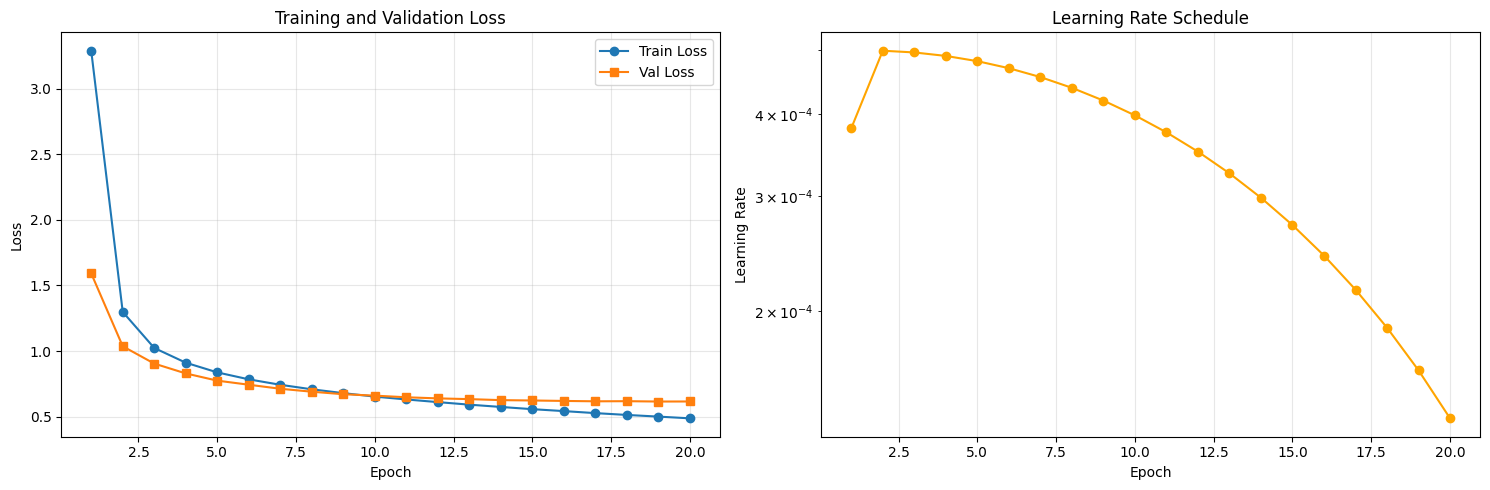

✅ Training curves saved to /content/checkpoints/training_curves.png


In [11]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss curves
axes[0].plot(history['epoch'], history['train_loss'], label='Train Loss', marker='o')
axes[0].plot(history['epoch'], history['val_loss'], label='Val Loss', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Learning rate
axes[1].plot(history['epoch'], history['learning_rate'], marker='o', color='orange')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Learning Rate')
axes[1].set_title('Learning Rate Schedule')
axes[1].set_yscale('log')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f"{CHECKPOINT_DIR}/training_curves.png", dpi=150, bbox_inches='tight')
plt.show()

print(f"✅ Training curves saved to {CHECKPOINT_DIR}/training_curves.png")

## Step 10: Load Best Model and Test

In [12]:
# Load best checkpoint
print("\n📂 Loading best model...")
checkpoint = torch.load(f"{CHECKPOINT_DIR}/best_model.pt", weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print(f"✅ Best model loaded (val_loss: {checkpoint['val_loss']:.4f})")
print(f"   Trained for {checkpoint['epoch']+1} epochs")

# Test on various problems
test_problems = [
    "Problem: Solve for x: 3x + 7 = 22\n\nSolution:",
    "Problem: What is the square root of 144?\n\nSolution:",
    "Problem: If f(x) = 2x + 3, find f(5)\n\nSolution:",
    "Problem: Calculate 15 × 12\n\nSolution:",
    "Problem: Find the area of a circle with radius 5\n\nSolution:"
]

print(f"\n{'='*70}")
print("🧪 FINAL MODEL TESTING")
print(f"{'='*70}\n")

for i, problem in enumerate(test_problems):
    print(f"\n{'─'*70}")
    print(f"Test {i+1}: {problem.split('Solution:')[0].strip()}")
    print(f"{'─'*70}")

    output = generate_sample(model, tokenizer, problem, max_length=256)

    # Extract just the solution part
    if "Solution:" in output:
        solution = output.split("Solution:")[1].strip()
        print(solution[:400])  # Print first 400 chars
    else:
        print(output[:400])
    print()

print(f"{'='*70}")
print("✅ Testing complete!")
print(f"{'='*70}")


📂 Loading best model...
✅ Best model loaded (val_loss: 0.6155)
   Trained for 19 epochs

🧪 FINAL MODEL TESTING


──────────────────────────────────────────────────────────────────────
Test 1: Problem: Solve for x: 3x + 7 = 22
──────────────────────────────────────────────────────────────────────
$2x + 7 = 22$. Step 1: Solution Subtracting 1 from both sides gives $2x + 7 = 22$. Subtracting 1 from both sides gives $x = \boxed{11}$. 11


──────────────────────────────────────────────────────────────────────
Test 2: Problem: What is the square root of 144?
──────────────────────────────────────────────────────────────────────
$144=2^4$. Step 1: Solution We can see that $144=2^2$, so $144=2^2$, and $144=2^2$. The square root is $\boxed{2^4}$. 2^4


──────────────────────────────────────────────────────────────────────
Test 3: Problem: If f(x) = 2x + 3, find f(5)
──────────────────────────────────────────────────────────────────────
$f^{-1}(2) = 3$. Step 1: Solution We have $f^{-1}(x) = 3x 

## Step 11: Interactive Demo - Try Your Own Problems!

In [13]:
def solve_math_problem(problem_text):
    """Solve a math problem using the trained model"""
    prompt = f"Problem: {problem_text}\n\nSolution:"
    output = generate_sample(model, tokenizer, prompt, max_length=400)

    # Extract solution
    if "Solution:" in output:
        solution = output.split("Solution:")[1]
        # Try to extract answer
        if "<answer>" in solution and "</answer>" in solution:
            answer = solution.split("<answer>")[1].split("</answer>")[0].strip()
            return solution, answer
        return solution, None
    return output, None

print("\n🎯 Interactive Math Problem Solver")
print("="*70)
print("Enter your math problem below (or press Enter to skip):\n")

# Example usage (you can modify this)
custom_problem = "Find the value of x if 5x - 8 = 17"

if custom_problem:
    print(f"Problem: {custom_problem}\n")
    solution, answer = solve_math_problem(custom_problem)
    print("Solution:")
    print("-" * 70)
    print(solution[:500])
    if answer:
        print(f"\nFinal Answer: {answer}")
    print("-" * 70)
else:
    print("(No custom problem provided, skipping interactive demo)")

print("\n✅ Demo complete! Modify the 'custom_problem' variable above to try different problems.")


🎯 Interactive Math Problem Solver
Enter your math problem below (or press Enter to skip):

Problem: Find the value of x if 5x - 8 = 17

Solution:
----------------------------------------------------------------------
 $$\frac{7x + 8}{x - 8} = 17.$$ Step 1: Solution We can simplify the equation as $$\frac{7x + 8}{x - 8} = 17.$$Subtracting $8.$ Subtracting $8$ from both sides gives $x = \boxed{-16}.$ -16
----------------------------------------------------------------------

✅ Demo complete! Modify the 'custom_problem' variable above to try different problems.


## Step 12: Save Final Model Metadata

In [14]:
import json

# Create metadata
metadata = {
    "model_size": MODEL_SIZE,
    "total_parameters": total_params,
    "training_examples": len(train_probs),
    "validation_examples": len(val_probs),
    "best_val_loss": best_val_loss,
    "final_epoch": epoch + 1,
    "hyperparameters": {
        "batch_size": BATCH_SIZE,
        "grad_accum_steps": GRAD_ACCUM_STEPS,
        "learning_rate": LEARNING_RATE,
        "max_length": MAX_LENGTH,
        "warmup_steps": WARMUP_STEPS,
    },
    "model_config": {
        "hidden_size": config.hidden_size,
        "num_layers": config.num_hidden_layers,
        "num_heads": config.num_attention_heads,
        "intermediate_size": config.intermediate_size,
    },
    "dataset": "MATH" if USE_FULL_DATASET else "MATH-500",
    "training_date": datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
}

# Save metadata
with open(f"{CHECKPOINT_DIR}/model_metadata.json", 'w') as f:
    json.dump(metadata, f, indent=2)

print("\n📊 Model Metadata:")
print(json.dumps(metadata, indent=2))
print(f"\n✅ Metadata saved to {CHECKPOINT_DIR}/model_metadata.json")


📊 Model Metadata:
{
  "model_size": "tiny",
  "total_parameters": 6573312,
  "training_examples": 10625,
  "validation_examples": 1250,
  "best_val_loss": 0.6155099627698303,
  "final_epoch": 20,
  "hyperparameters": {
    "batch_size": 8,
    "grad_accum_steps": 4,
    "learning_rate": 0.0005,
    "max_length": 512,
    "warmup_steps": 200
  },
  "model_config": {
    "hidden_size": 256,
    "num_layers": 6,
    "num_heads": 8,
    "intermediate_size": 1024
  },
  "dataset": "MATH",
  "training_date": "2025-12-20 17:42:03"
}

✅ Metadata saved to /content/checkpoints/model_metadata.json


## 🎉 Training Complete!

### What's Saved:
- ✅ `best_model.pt` - Best performing model checkpoint
- ✅ `checkpoint_epoch_*.pt` - Periodic checkpoints
- ✅ `training_curves.png` - Loss and LR visualization
- ✅ `model_metadata.json` - Complete training information

### Next Steps:
1. **Download the model**: From the Files panel (left sidebar)
2. **Use locally**: Load the checkpoint in your local environment
3. **Evaluate**: Test on the MATH test set for proper evaluation
4. **Fine-tune**: Continue training with more data or adjust hyperparameters

### Expected Results:
- With **7,500 examples**: Model should show basic mathematical reasoning
- **Validation loss < 1.0**: Good sign of learning
- **Coherent outputs**: Should generate valid mathematical steps
- **Simple problems**: Should solve basic algebra correctly

### If Results are Poor:
- ✅ Try training for more epochs
- ✅ Use a smaller model ("tiny" size)
- ✅ Lower learning rate (5e-5)
- ✅ Add more data augmentation

---

**Need help?** Check the repository issues or documentation!